# Análisis espectral de un fragmento de señal

En este cuaderno comenzaremos a ver cómo obtener el espectro de una señal, es decir **cómo descomponerla como suma de sinusoides**

Para ello analizaremos sonidos producidos por un instrumento musical.

La herramienta básica de análisis que emplearemos será la DFT/FFT. Como sabemos de teoría:

 * la DFT trata de estimar las amplitudes y fases en un conjunto discreto de frecuencias.
 
 * El conjunto de frecuencias se puede hacer tan denso como se desee sin más que añadir ceros a las muestras de la señal antes de empezar.
 
 * La DFT realiza una suma en vez de una media, por lo que para estimar las amplitudes hay que dividor por *L*, el número de muestras de señal empleado.
 
 * Las amplitudes de las sinusoides (espectro unilateral) se obtienen multiplicando por 2 las amplitudes de los fasores (espectro bilateral)
 
 * El cálculo de la DFT se puede hacer de manera especialmente eficiente si el número de muestras (incluido el relleno por ceros) es **potencia entera de 2**. El caso más desfavorable es cuando el número de muestras es primo y grande.

In [7]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore') # Para quitar mensajes de warning
import upv_audio 
matplotlib.rcParams['figure.figsize'] = (10, 5)
from IPython.display import Audio

import UPVlog
notebook_filename="2-6 Analisis Espectral Guitarra"
mylogger=UPVlog.UPVlog(notebook_filename)

Comenzaremos leyendo una señal de audio que contiene una pulsación de una cuerda de una guitarra. Si el alumno lo desea, puede emplear grabaciones propias de cualquier instrumento de cuerda o viento

In [31]:
#Esto lo dejaremos para cuando lo necesitemos
f_cuerdas  = [329.63, 246.94, 196.00, 146.8, 110, 82.41]
#leemos el audio
fs,x=upv_audio.read('audios/guitarra/c6.wav')
print(fs)
print(x.shape)

44100
(275252,)


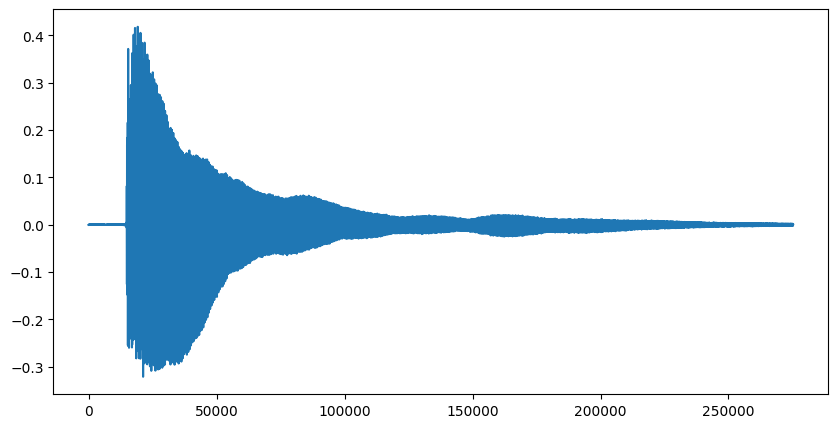

In [32]:
#Representamos a ver qué tenemos
%matplotlib inline
_=plt.plot(x)

Analizaremos un fragmento de la señal en el que esta sea estable. Por ejemplo a partir de la muestra **40000**

Representaremos un pequeño fragmento para comprobar que es *aproximádamente* periódica

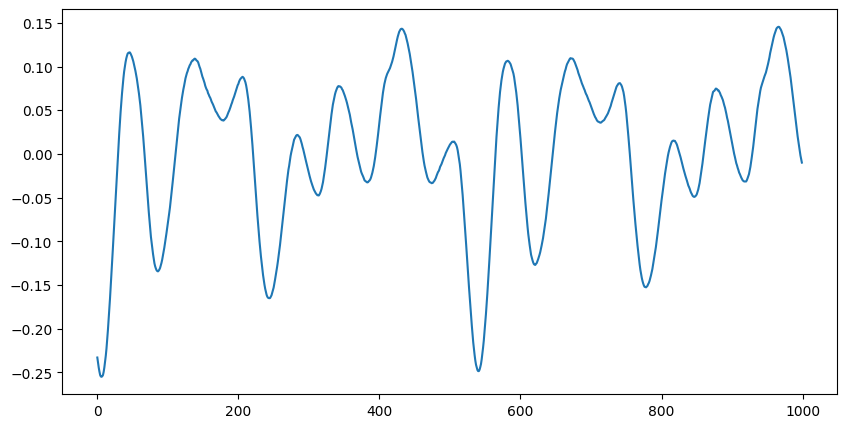

In [33]:
_=plt.plot(x[40000:41000])

A *ojo* podemos ver que el periodo son una 220 muestras, que corresponde con una frecuencia de $f_s /220 =$

In [34]:
fs/220.0

200.45454545454547

Podemos ver que es similar a la tercera cuerda, pese a haber elegido el periodo totalmente *a ojo*

In [35]:
f_cuerdas[3-1] # La primera cuerda es el elemento 0

196.0

Para empezar el **análisis de verdad**, tomaremos un fragmento de medio segundo empezando en la muestra 40000

In [36]:
ini=40000
fin = ini + int(fs*0.5)
trozo=x[ini:fin]

In [37]:
def espectroFFT(x, NFFT=None):
    
    # Si no damos NFFT es directamente la longitud de la señal
    L=len(x)
    if NFFT==None:
        NFFT = L 
       
    # Comprobamos que NFFT sea mayor que la longitud de x.
    assert L<=NFFT, 'NFFT tiene que ser mayor o igual a que len(x)'

    # Calculamos la FFT. Se rellena con ceros desde L a NFFT 
    X = np.fft.fft(x,NFFT)
   
    A=2/L*np.abs(X)
   
    # Generamos el eje de frecuencia digital
    fd = np.arange(0, NFFT)/NFFT
    
  # Nos quedamos con la primera mitad (hasta frec 0.5)
    A=A[0:NFFT//2]
    fd=fd[0:NFFT//2]
    
    return A,fd 

In [38]:
X,f=espectroFFT(trozo)

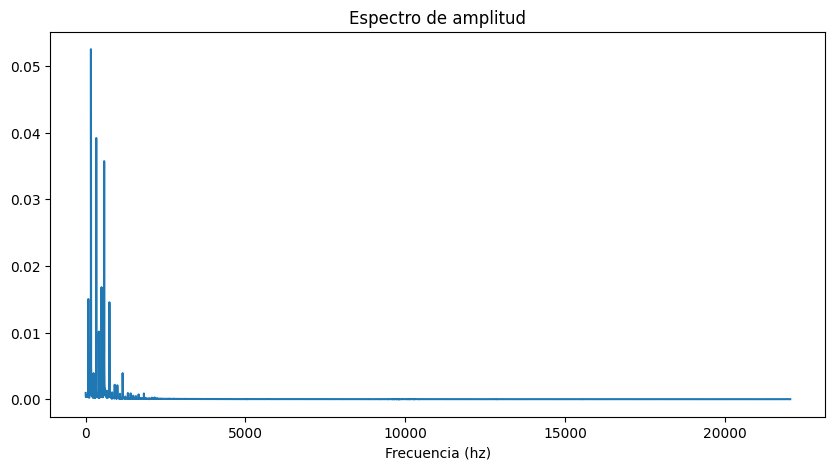

In [39]:
_=plt.plot(f*fs,X)
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')

Se puede observar:
* Estructura de armónicos de la señal
* Que el armónico de más amplitud **NO** es el fundamental.
* Que las amplitudes son prácticamente 0 por encima de 2 kHz

Podemos hace zoom en el eje horizontal para ver mejor.

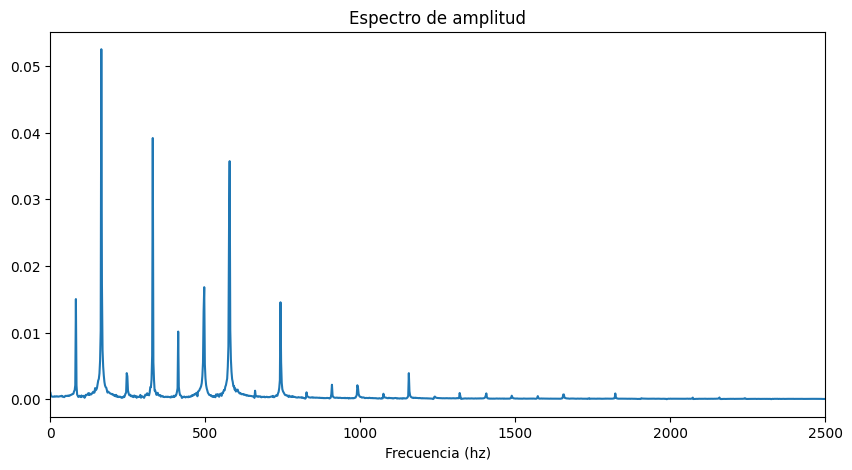

In [40]:
%matplotlib inline
_=plt.plot(f*fs,X)
_=plt.xlim((0,2500))
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')

Ahora haremos algo parecido pero rellenando por ceros 

* hasta aprox. el triple del tamaño de la señal
* Buscando que el número sea potencia entera de 2

In [18]:
NFFT=2**math.ceil(math.log2(3*len(trozo)))
print('NFFT=',NFFT)

NFFT= 131072


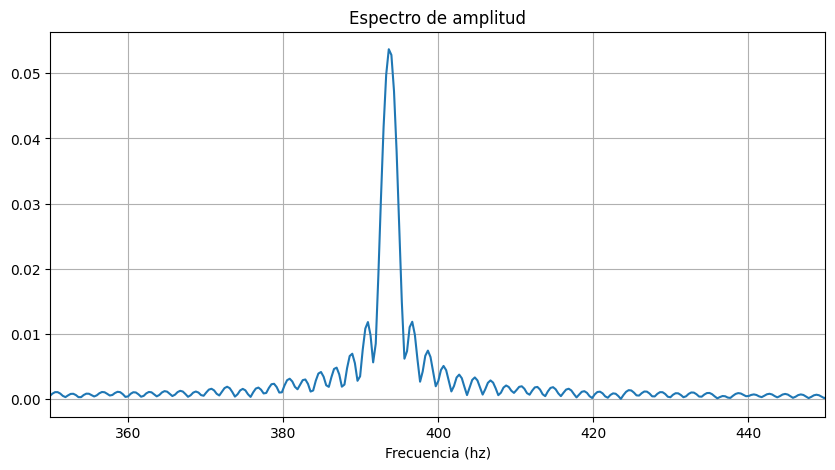

In [19]:
#Efecto de muestrear más fino en la frecuencia
X2,f2=espectroFFT(trozo,NFFT)
_=plt.plot(f2*fs,X2)
_=plt.xlim((350,450))
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')
_=plt.grid()

Podemos observar dos efectos por haber tomado un fragmento de señal de duración finita:
* Lóbulo principal de anchura no nula
* Lóbulos secundarios alrededor del pico principal

**Hay que saber interpretar que ambas cosas son *efectos secundarios* por el hecho de analizar un fragmento finito de señal**

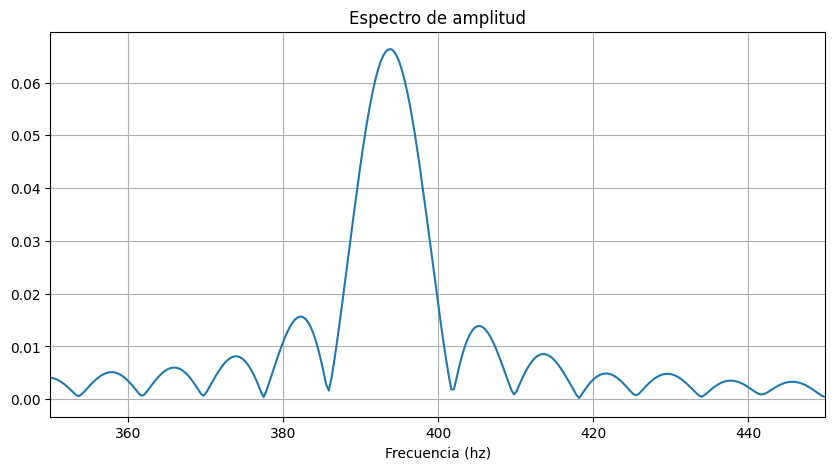

In [20]:
#Efecto de tomar distintas longitudes de la señal
X3,f3=espectroFFT(trozo[:len(trozo)//4],NFFT)
_=plt.plot(f3*fs,X3)
_=plt.xlim((350,450))
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')
_=plt.grid()

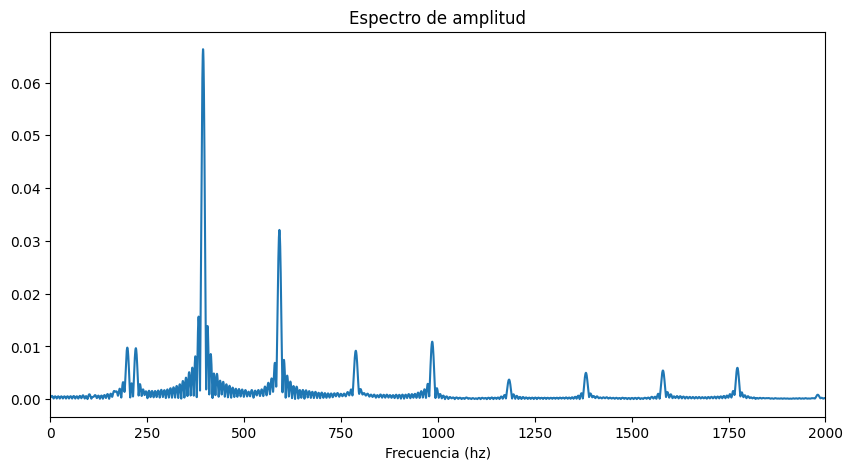

In [21]:
_=plt.plot(f3*fs,X3)
_=plt.xlim((0,2000))
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')

## Observaciones
Conviene hacerles observar:

* Que al tomar la señal más corta el lóbulo principal se hace más ancho

* Que los lóbulos secundarios próximos al lóbulo principal son relativamente grandes

* Que algunas de las componentes espectrales tienen amplitudes menores que algunos lóbulos secundarios.

* Que la relación Principal/secundario no cambia con L

* Que a señal más larga todo mejora

  * Pero no siempre tendremos muuucho tiempo la señal estable (notas rápidas)
  
  * Se tarda más tiempo en realizar la medida